In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches
import pandas as pd
from astropy import coordinates
from astropy import units as u
from skipper import observe, planner

In [3]:
import sys
sys.path.append('../scripts/')

In [4]:
import sigjson_f2022b
import our_pointings

In [5]:
obsdates = sigjson_f2022b.obsdates

In [6]:
obskeys = [ f'{x[0]:02d}-{x[1]:02d}-{x[2]:02d}' for x in obsdates[:,:3]]

In [7]:
def wrapRA(ra, wrap_point=180.):
    mask = ra >= wrap_point
    wrapped_ra = ra.copy()
    wrapped_ra[mask] -= 360.
    return wrapped_ra

# OIII observation simulation

In [8]:
obsdates = sigjson_f2022b.obsdates
obsfilters = sigjson_f2022b.obsfilters

oiii_nights = obsdates[obsfilters == 'N540', :-1]
halpha_nights = obsdates[obsfilters=='N708',:-1]

tele_fname = '/Users/kadofong/Downloads/tele20220310.csv'
copilot_fname = '/Users/kadofong/Downloads/db_merian.fits'

hcat, ocat = our_pointings.load_fallfields ()

coo_o = observe.CopilotOutput ( copilot_fname, ocat )
coo_h = observe.CopilotOutput ( copilot_fname, hcat )

In [9]:
oiii_nights

array([[2022,    9,   20,    2],
       [2022,    9,   22,    2],
       [2022,    9,   27,    0],
       [2022,    9,   28,    0],
       [2022,   10,    2,    2]])

In [10]:
night = oiii_nights[1]

dt = f'{night[0]}{night[1]:02d}{night[2]:02d}' #20220920
if not os.path.exists ( f'../json/{dt}'):
    os.mkdir(f'../json/{dt}')
    
stdout = sys.stdout
with open(f'../json/{dt}/output.log','w') as sys.stdout:
    is_queued = sigjson_f2022b.plan_tomorrow( night[2], night[1], night[0], tele_fname, 
                                             copilot_fname, mfilt='N540', is_queued=None, 
                                             pad_last_hour=True, maxairmass=1.8, save=True, verbose=True)
sys.stdout = stdout

In [11]:
to_obs = is_queued.loc[~is_queued['qstamp'].isna()]

/var/folders/py/1g64k0fx3rd03lcwckrdjbt80000gn/T/ipykernel_26403/1783440112.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  to_obs['odate'] = to_obs.apply(lambda x: x['qstamp'].split("_")[0], axis=1)


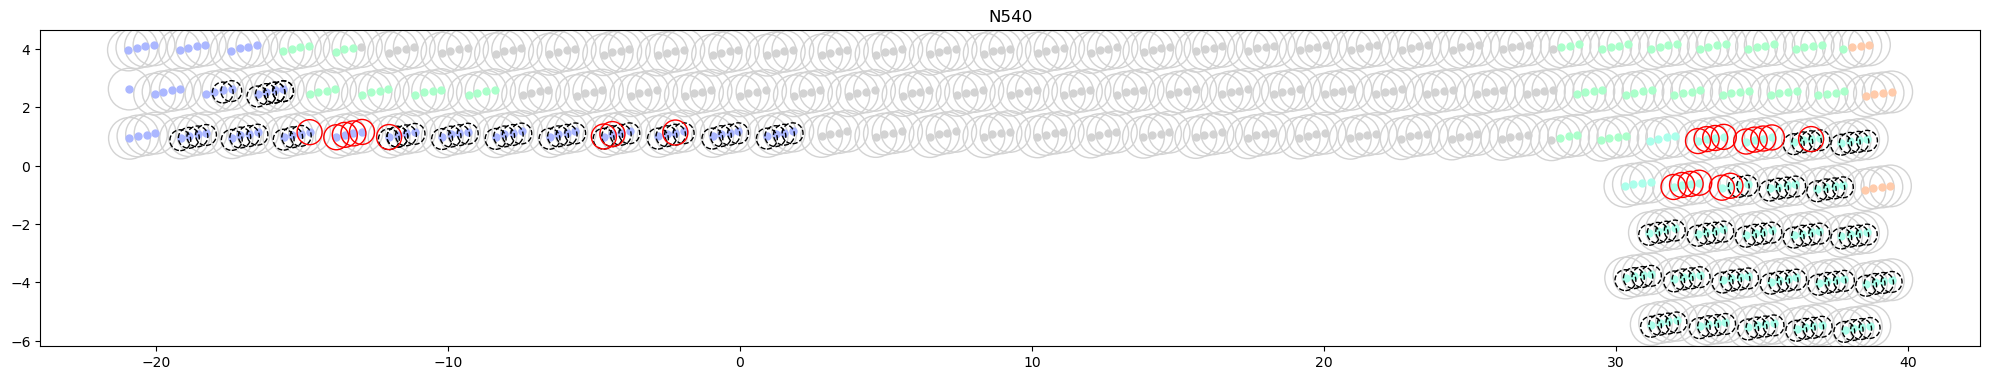

In [12]:
fields = ocat['object'].str.extract(r'(.*?(?=_))')[0]

fig = plt.figure(figsize=(20,4))
ax = plt.subplot(111)
ax.set_aspect('equal')

cc_l = ['#abb7ff','#abffeb','#abffcb','#feffab','#ffcbab','lightgrey']
#['tab:red','tab:blue','tab:green','tab:purple','grey','tab:orange']
#['#abb7ff','#abffeb','#abffcb','#feffab','#ffcbab','lightgrey']

plt.scatter ( wrapRA(hcat['RA']), hcat['dec'], facecolor='None', edgecolor='lightgrey', s=30**2)
for field in fields.unique():
    cat = ocat.loc[fields==field]
    idx = sigjson_f2022b._field_priorities[field]
    plt.scatter ( wrapRA(cat['RA']), cat['dec'], c=cc_l[idx], s=5**2)
    
plt.scatter ( wrapRA(coo_o.merian_sidecar['racenter']), coo_o.merian_sidecar['deccenter'], 
             facecolor='None', edgecolor='k', s=15**2, ls='--' )

to_obs['odate'] = to_obs.apply(lambda x: x['qstamp'].split("_")[0], axis=1)

#grps = to_obs.groupby('odate')
#for idx,(name,grp) in enumerate(grps):
#    cc = plt.cm.Dark2(idx/grps.ngroups)
#    plt.scatter ( wrapRA(ocat.reindex(grp.index)['RA']), ocat.reindex(grp.index)['dec'], facecolor='None', edgecolor=cc, s=18**2, lw=1 )
#    print(grp.shape[0])
plt.scatter ( wrapRA(ocat.reindex(to_obs.index)['RA']), ocat.reindex(to_obs.index)['dec'], 
             facecolor='None', edgecolor='r', s=18**2, lw=1 )

#plt.axvline(38.)
plt.title('N540')
plt.tight_layout ()
#plt.savefig('/Users/kadofong/Downloads/N540_2022Bprediction.png')

In [18]:
tele = pd.read_csv('/Users/kadofong/Downloads/tele20220310.csv', index_col=0)

In [25]:
tele_dt = pd.to_datetime(tele['date'])

In [37]:
lastnight = pd._libs.tslibs.timestamps.Timestamp(year=night[0], month=night[1], day=night[2], tz='UTC')

In [101]:
# \\ need to match OIII planned observations to Halpha catalog

# \\ load N708 & N540 pointings
halpha_locations = coordinates.SkyCoord( hcat['RA'], hcat['dec'], unit=('deg','deg'))
planned_oiii_obscoords = coordinates.SkyCoord( ocat.reindex(is_queued.loc[is_queued['is_queued']].index)['RA'], 
                                              ocat.reindex(is_queued.loc[is_queued['is_queued']].index)['dec'], 
                                              unit=('deg','deg'))
# \\ match via coordinates
matchids, sep, _ = planned_oiii_obscoords.match_to_catalog_sky ( halpha_locations )
matches = sep < 0.05*u.arcsec

# \\ aggregate all Halpha pointings that are in the OIII queue
nominally_new_inN708 = hcat.index[matchids]
#nominally_new_inN708['qstamp'] = to_obs['qstamp']
# \\ identify which pointings have already been observed in Halpha
already_observed_inN708 = np.in1d(hcat.reindex(nominally_new_inN708)['object'], coo_h.merian_sidecar['object'])
truly_new_inN708 = hcat.reindex(nominally_new_inN708).loc[~already_observed_inN708].copy()
truly_new_inN708['qstamp'] = is_queued.query('is_queued').loc[~already_observed_inN708, 'qstamp'].values
#truly_new_inN708['object'] = truly_new_inN708['object'].apply ( lambda x: 'OIIIanalog_' + x.split('_')[1] )

# \\ the pointings that "can" be observed should be the truly new in queue
# \\ PLUS XMM pointings, but XMM should be downgraded
hcat_fields = hcat['object'].str.extract(r'(.*?(?=_))')[0]
is_xmm = hcat_fields == 'XMM'
#is_xv = hcat_fields == 'btwnXV'
xmmtogo = hcat.loc[is_xmm].copy ()
xmmtogo['qstamp'] = 'NONE'

hack_cat = pd.concat([truly_new_inN708, xmmtogo])
# \\ remove pointings that are both in XMM and scheduled for 
# \\ OIII observations
hack_cat = hack_cat.loc[~hack_cat.index.duplicated( keep='first')]
hack_cat['qstamp'] = hack_cat['qstamp'].replace(np.NaN, 'NONE')

In [1]:
import re

def find_queue_today ( year, month, day, hack_cat, dd=1 ):
    '''
    Only allow us to queue observations from yesterday
    '''
    # \\ get observed pointings from the last time we observed
    lastnight = pd._libs.tslibs.timestamps.Timestamp(year=year, month=month, day=day-dd, tz='UTC')
    observed_last_night = tele.loc[tele_dt.apply(lambda x: x > lastnight),'object'] # XXX check if this is with field names or not
    analogous = hack_cat.reindex(observed_last_night ) 
    # \\ add in XMM non-analogs
    nonanalogous = hack_cat['qstamp'] == 'NONE'
    in_queue_today = analogous|nonanalogous
    return in_queue_today


In [109]:
#is_queued = pd.DataFrame(index=hcat.index, columns=['is_queued','qstamp','airmass'])
halpha_priorities = {'VVDSearly':0, 'VVDSlate':0, 'VVDS':0, 'XMM':100, 'btwnXV':2, 'XMMhigh':4, 'newRAbtwnXV':5}
inq = []

for idx in range(len(halpha_nights)):
    night = halpha_nights[idx]
    # \\ only allow for observations from the analogous night
    if idx < len(oiii_nights):
        #opad = 2
        oiii_analog = oiii_nights[idx]    
        oiii_next = oiii_nights[idx+1] 
        iqt = find_queue_today( oiii_analog[0], oiii_analog[1], oiii_analog[2], hack_cat )    
        iqt_next = find_queue_today( oiii_next[0], oiii_next[1], oiii_next[2], hack_cat )
        todaycat = hack_cat.loc[iqt|iqt_next]
    else:
        iqt = hack_cat['qstamp'] == "NONE"
        todaycat = hack_cat.loc[iqt]

    isqueuedtoday = pd.DataFrame(index=todaycat.index, columns=['is_queued','qstamp','airmass'])      
    isqueuedtoday['is_queued'] = False
    overlap = isqueuedtoday.index.intersection(inq)
    isqueuedtoday.loc[overlap,'is_queued']=True        
    
    is_queued_halpha = sigjson_f2022b.plan_tomorrow( night[2], night[1], night[0], 
                                             tele_fname, copilot_fname, mfilt='N708', 
                                             pointings=todaycat,
                                             is_queued=isqueuedtoday, 
                                             priorities = halpha_priorities,
                                             pad_last_hour=False, maxairmass=1.9, save=False, verbose=False)
    inq.extend(is_queued_halpha.index[~is_queued_halpha['qstamp'].isna()])
    
#to_obs_halpha = is_queued.reindex(inq)
#to_obs_halpha['odate'] = to_obs_halpha.apply(lambda x: x['qstamp'].split("_")[0], axis=1)

[verify_synchronicity] last exposure in logs is 1087049, taken at 2022-03-11 09:22:22.530928+00:00
On 2022/9/21, we are observing None in N708
We are observing the second half of the night
0 pointings in this catalog need reobservation!


[predict] night slot: Second half
Moon illumination is: 0.13
Moon max altitude during observation is: 4.56
[plan_night] Inferring priorities from object names



(Minimum airmass available: 1.172999060956252)
==> 20220922_04, 1440.0000000000077s available
1200.0s filled by priority=0.0 objects
0.0s filled by priority=100.0 objects

(Minimum airmass available: 1.1602809423903118)
==> 20220922_05, 3600.0s available
3600.0s filled by priority=0.0 objects
0.0s filled by priority=100.0 objects

(Minimum airmass available: 1.1040977691921456)
==> 20220922_06, 3600.0s available
3600.0s filled by priority=0.0 objects
0.0s filled by priority=100.0 objects

(Minimum airmass available: 1.1038118618586665)
==> 20220922_07, 3600.0s available
0.0s filled by priority=0.0 objects
3600.0s filled by priority=100.0 objects

(Minimum airmass available: 1.1721306732065007)
==> 20220922_08, 3600.0s available
0.0s filled by priority=0.0 objects
3600.0s filled by priority=100.0 objects

(Minimum airmass available: 1.3489311500118701)
==> 20220922_09, 1859.9999999999613s available
0.0s filled by priority=0.0 objects
1800.0s filled by priority=100.0 objects
[verify_syn

[predict] night slot: Second half
Moon illumination is: 0.03
Moon max altitude during observation is: 0.00
[plan_night] Inferring priorities from object names



(Minimum airmass available: 1.2616540942122927)
==> 20220924_04, 1470.0000000000125s available
1200.0s filled by priority=0.0 objects
0.0s filled by priority=2.0 objects
0.0s filled by priority=100.0 objects

(Minimum airmass available: 1.148247943811503)
==> 20220924_05, 3600.0s available
3600.0s filled by priority=0.0 objects
0.0s filled by priority=2.0 objects
0.0s filled by priority=100.0 objects

(Minimum airmass available: 1.102389066534687)
==> 20220924_06, 3600.0s available
600.0s filled by priority=0.0 objects
3000.0s filled by priority=2.0 objects
0.0s filled by priority=100.0 objects

(Minimum airmass available: 1.1156424930641204)
==> 20220924_07, 3600.0s available
0.0s filled by priority=0.0 objects
3000.0s filled by priority=2.0 objects
600.0s filled by priority=100.0 objects

(Minimum airmass available: 1.204180580479082)
==> 20220924_08, 3600.0s available
0.0s filled by priority=0.0 objects
0.0s filled by priority=2.0 objects
3600.0s filled by priority=100.0 objects

(

[predict] night slot: Full night
Moon illumination is: 0.20
Moon max altitude during observation is: 35.32
[plan_night] Inferring priorities from object names



(Minimum airmass available: 1.8847499274889983)
==> 20220929_23, 839.9999999999907s available
600.0s filled by priority=0.0 objects
0.0s filled by priority=2.0 objects
0.0s filled by priority=100.0 objects

(Minimum airmass available: 1.4776976746761266)
==> 20220930_00, 3600.0s available
1800.0s filled by priority=0.0 objects
1800.0s filled by priority=2.0 objects
0.0s filled by priority=100.0 objects

(Minimum airmass available: 1.3249284150370415)
==> 20220930_01, 3600.0s available
0.0s filled by priority=0.0 objects
3600.0s filled by priority=2.0 objects
0.0s filled by priority=100.0 objects

(Minimum airmass available: 1.2198256034866166)
==> 20220930_02, 3600.0s available
0.0s filled by priority=0.0 objects
3600.0s filled by priority=2.0 objects
0.0s filled by priority=100.0 objects

(Minimum airmass available: 1.1896735206117306)
==> 20220930_03, 3600.0s available
0.0s filled by priority=0.0 objects
3600.0s filled by priority=2.0 objects
0.0s filled by priority=100.0 objects

(

[predict] night slot: Full night
Moon illumination is: 0.30
Moon max altitude during observation is: 48.46
[plan_night] Inferring priorities from object names

(Minimum airmass available: 3.324207787999201)
==> 20220930_23, 839.9999999999907s available
0.0s filled by priority=0.0 objects
0.0s filled by priority=2.0 objects
0.0s filled by priority=4.0 objects
0.0s filled by priority=100.0 objects
!!! Nothing to queue !!!

(Minimum airmass available: 2.010506328293724)
==> 20221001_00, 3600.0s available
0.0s filled by priority=0.0 objects
0.0s filled by priority=2.0 objects
0.0s filled by priority=4.0 objects
0.0s filled by priority=100.0 objects
!!! Nothing to queue !!!

(Minimum airmass available: 1.5191896610134035)
==> 20221001_01, 3600.0s available
0.0s filled by priority=0.0 objects
600.0s filled by priority=2.0 objects
0.0s filled by priority=4.0 objects
0.0s filled by priority=100.0 objects
!!! Cannot fill queue !!! 3000.0, 600.0


/Users/kadofong/work/observing/merian/skipper/python/skipper/observe.py:400: UserWarning: Queue empty at 20220930_23
  warnings.warn (f'Queue empty at {hstr}')
/Users/kadofong/work/observing/merian/skipper/python/skipper/observe.py:400: UserWarning: Queue empty at 20221001_00
  warnings.warn (f'Queue empty at {hstr}')
/Users/kadofong/work/observing/merian/skipper/python/skipper/observe.py:403: UserWarning: Queue unfilled at 20221001_01
  warnings.warn(f'Queue unfilled at {hstr}')



(Minimum airmass available: 1.850190814014548)
==> 20221001_02, 3600.0s available
0.0s filled by priority=0.0 objects
0.0s filled by priority=2.0 objects
0.0s filled by priority=4.0 objects
3600.0s filled by priority=100.0 objects

(Minimum airmass available: 1.4348105134135403)
==> 20221001_03, 3600.0s available
0.0s filled by priority=0.0 objects
3600.0s filled by priority=2.0 objects
0.0s filled by priority=4.0 objects
0.0s filled by priority=100.0 objects

(Minimum airmass available: 1.2184543873670801)
==> 20221001_04, 3600.0s available
0.0s filled by priority=0.0 objects
3600.0s filled by priority=2.0 objects
0.0s filled by priority=4.0 objects
0.0s filled by priority=100.0 objects

(Minimum airmass available: 1.1218986748087816)
==> 20221001_05, 3600.0s available
0.0s filled by priority=0.0 objects
2400.0s filled by priority=2.0 objects
600.0s filled by priority=4.0 objects
600.0s filled by priority=100.0 objects

(Minimum airmass available: 1.1171075832729436)
==> 20221001_06,

[predict] night slot: Second half
Moon illumination is: 0.75
Moon max altitude during observation is: 38.86
[plan_night] Inferring priorities from object names



(Minimum airmass available: 1.1945185910618872)
==> 20221005_04, 1710.0000000000211s available
0.0s filled by priority=0.0 objects
1200.0s filled by priority=2.0 objects
0.0s filled by priority=4.0 objects
0.0s filled by priority=100.0 objects

(Minimum airmass available: 1.123980625216929)
==> 20221005_05, 3600.0s available
0.0s filled by priority=0.0 objects
3600.0s filled by priority=2.0 objects
0.0s filled by priority=4.0 objects
0.0s filled by priority=100.0 objects

(Minimum airmass available: 1.131955247267315)
==> 20221005_06, 3600.0s available
0.0s filled by priority=0.0 objects
3000.0s filled by priority=2.0 objects
600.0s filled by priority=4.0 objects
0.0s filled by priority=100.0 objects

(Minimum airmass available: 1.1968838324939253)
==> 20221005_07, 3600.0s available
0.0s filled by priority=0.0 objects
0.0s filled by priority=2.0 objects
2400.0s filled by priority=4.0 objects
1200.0s filled by priority=100.0 objects

(Minimum airmass available: 1.3987196632493504)
==> 

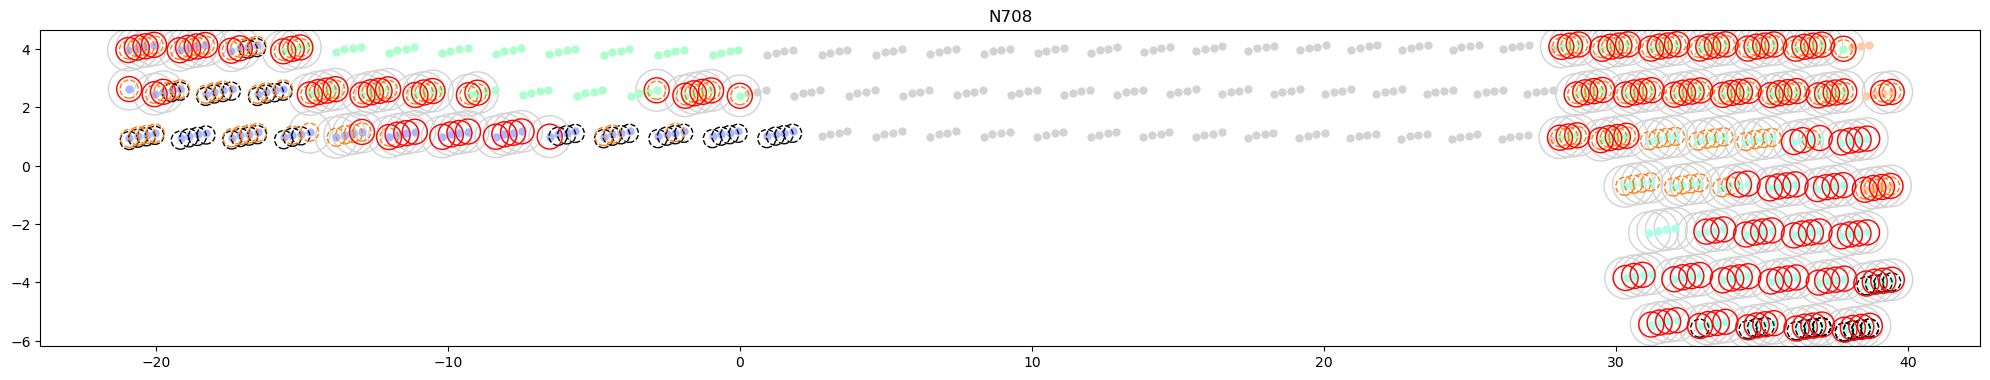

In [111]:
fig = plt.figure(figsize=(20,4))
ax = plt.subplot(111)
ax.set_aspect('equal')

plt.scatter ( wrapRA(hack_cat['RA']), hack_cat['dec'], facecolor='None', edgecolor='lightgrey', s=30**2)
for field in fields.unique():
    cat = ocat.loc[fields==field]
    idx = sigjson_f2022b._field_priorities[field]
    plt.scatter ( wrapRA(cat['RA']), cat['dec'], c=cc_l[idx], s=5**2)
    
plt.scatter ( wrapRA(coo_h.merian_sidecar['racenter']), 
             coo_h.merian_sidecar['deccenter'], facecolor='None', edgecolor='k', s=13**2, ls='--' )

plt.scatter ( wrapRA(ocat.reindex(to_obs.index)['RA']), ocat.reindex(to_obs.index)['dec'], 
             facecolor='None', edgecolor='C1', s=13**2, lw=1, ls='--' )
plt.scatter ( wrapRA(hcat.reindex(inq)['RA']), hcat.reindex(inq)['dec'], 
             facecolor='None', edgecolor='r', s=18**2, lw=1,  )

#plt.scatter ( wrapRA(truly_new_inN708['RA']), truly_new_inN708['dec'], facecolor='None', edgecolor='r', s=18**2, lw=1 )
#plt.scatter ( wrapRA(ocat.reindex(to_obs.index)['RA']), ocat.reindex(to_obs.index)['dec'], color='b', s=1)

plt.title('N708')
plt.tight_layout ()
plt.savefig('/Users/kadofong/Downloads/N708_2022Bprediction.png')

In [512]:
hack_queue = pd.DataFrame(index=hcat.index, columns=['is_queued','qstamp','airmass'])
#hack_queue.loc[truly_new_inN708.index, 'is_queued'] = True
hack_queue.loc[hcat.loc[np.in1d(hcat['object'], coo_h.merian_sidecar['object'])].index, 'is_queued'] = True
hack_queue.loc[truly_new_inN708.index, 'is_queued'] = True

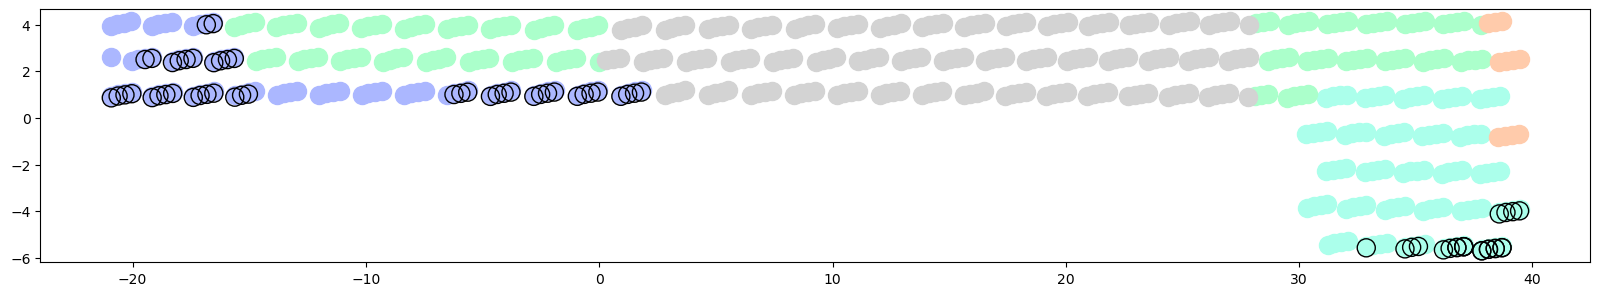

In [514]:
fig = plt.figure(figsize=(20,4))
ax = plt.subplot(111)
ax.set_aspect('equal')

for field in fields.unique():
    cat = ocat.loc[fields==field]
    idx = sigjson_f2022b.priorities[field]
    plt.scatter ( wrapRA(cat['RA']), cat['dec'], c=cc_l[idx], s=13**2)
    
plt.scatter ( wrapRA(ocat.reindex(grp.index)['RA']), ocat.reindex(grp.index)['dec'], facecolor='None', edgecolor=cc, s=18**2, lw=1 )
plt.scatter ( wrapRA(coo_h.merian_sidecar['racenter']), coo_h.merian_sidecar['deccenter'], facecolor='None', edgecolor='k', s=13**2 )
hq = hack_queue.reindex ( coo_h.merian_sidecar
plt.scatter ( wrapRA(hcat.reindex(

In [ ]:
is_queued = None
for idx in range(len(halpha_nights)):
    night = halpha_nights[idx]
    is_queued = sigjson_f2022b.plan_tomorrow( night[2], night[1], night[0], tele_fname, copilot_fname, mfilt='N708', is_queued=is_queued, pad_last_hour=False, maxairmass=1.8, save=False, verbose=False)
to_obs = is_queued.loc[~is_queued['qstamp'].isna()]

In [229]:
#night = obsdates[4]
#newq = sigjson_f2022b.plan_tomorrow( night[2], night[1], night[0], tele_fname, copilot_fname, mfilt='N540', is_queued=is_queued, pad_last_hour=False, maxairmass=1.6, save=False)
    

In [506]:
5 - (5.*10./15.)

1.6666666666666665

In [199]:
coo_o.merian_sidecar.loc[coo_o.merian_sidecar['racenter'] > 300., 'racenter'].min()

340.8357782548524

In [202]:
coo_h.merian_sidecar.loc[coo_h.merian_sidecar['racenter'] > 300., 'racenter'].min()

339.08456994156114